#ติดตั้ง Library ที่จำเป็น

#โหลด Dataset จาก Roboflow

In [ ]:
!pip install ultralytics

In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#  Train Model Yolo ด้วย Dataset ที่เตรียมไว้ Dataset Drone

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0100tTC6iSisNdselYOb")
project = rf.workspace("tung01").project("my-first-project01-l3lmj")
version = project.version(3)
dataset = version.download("yolov8")


In [ ]:
models = YOLO("yolov8s.pt")

In [ ]:
dataset="/content/My-First-Project01-3/data.yaml"

In [ ]:
models.info()

#ใช้ Augmentation มาช่วย ถ้ายังไม่ทำตอน preprocessing

In [ ]:
from ultralytics import YOLO

models = YOLO("yolov8m.pt")
# เทรนพร้อม custom augmentation
models.train(
    data=dataset,
    epochs=100,
    imgsz=640,
    augment=False,  # เปิดใช้ augmentation
    degrees=20,    # หมุน
    scale=0.5,     # random scale
    flipud=0.3,    # flip vertical
    fliplr=0.5,    # flip horizontal
    hsv_h=0.015,   # ปรับ hue
    hsv_s=0.7,     # ปรับ saturation
    hsv_v=0.4      # ปรับ brightness
)


In [ ]:
from google.colab import files
# ระบุเส้นทางของไฟล์ที่ต้องการดาวน์โหลด
file_path ='/content/runs/detect/train4/weights/best.pt'
# ดาวน์โหลดไฟล์
files.download(file_path)

# การนำโมเดลที่สำเร็จแล้วมาใช้ (ใน Colab)

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files
import os

## เรียกใช้โมเดลที่ Train ไว้แล้ว

In [ ]:
model_best_pt="/content/runs/detect/train/weights/best.pt"

In [ ]:
# โหลดโมเดล best
model = YOLO(model_best_pt)

In [ ]:
model.info()

In [ ]:
model.names

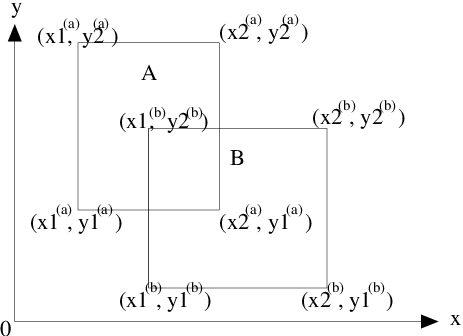
#
x1	พิกัดแนวนอนของมุมซ้ายบน	(บน–ซ้าย)
y1	พิกัดแนวตั้งของมุมซ้ายบน	(บน–ซ้าย)
x2	พิกัดแนวนอนของมุมขวาล่าง	(ล่าง–ขวา)
y2	พิกัดแนวตั้งของมุมขวาล่าง	(ล่าง–ขวา)

In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO

In [ ]:
import pandas as pd
from ultralytics import YOLO
import os
import cv2
import glob # สำหรับวนลูปไฟล์ในโฟลเดอร์
import numpy as np # เพิ่มสำหรับใช้ในการตรวจสอบขนาดภาพ ถ้าคุณต้องการใช้การตรวจสอบขนาดภาพ 1920x1080

# ตรวจสอบว่าได้ Mount Google Drive แล้วหรือไม่
try:
    from google.colab import drive
    # drive.mount('/content/drive', force_remount=True) # หากยังไม่ได้ mount ให้รันบรรทัดนี้
except ImportError:
    pass

# ==============================================================================
# --- 1. SETUP & LOAD MODEL ---
# ==============================================================================
# สมมติว่าไฟล์โมเดลของคุณอยู่ที่ตำแหน่งเดิม
model_best_pt="/content/runs/detect/train2/weights/best.pt"
INPUT_IMAGE_DIR = "/content/drive/MyDrive/Drone_test/TEST_DATA"

# ตรวจสอบและสร้างโฟลเดอร์สำหรับผลลัพธ์
OUTPUT_DIR = "Yolov8s_CSV_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_CSV_PATH = os.path.join(OUTPUT_DIR, "detection_results.csv")

try:
    model = YOLO(model_best_pt)
    print(f"✅ โมเดลถูกโหลดสำเร็จจาก: {model_best_pt}")
    class_name_dict = model.names
    print(f"โมเดลมี {len(class_name_dict)} คลาส: {class_name_dict}")
except Exception as e:
    print(f"!!! ไม่สามารถโหลดโมเดล YOLO ได้: {e}")
    model = None

# ==============================================================================
# --- 2. MAIN PROCESSING FUNCTION ---
# ==============================================================================
def process_images_to_csv(model, image_dir, output_csv_path):
    """
    ทำการตรวจจับวัตถุในทุกรูปภาพใน image_dir และบันทึกผลลัพธ์ลงในไฟล์ CSV
    """
    if model is None:
        print("ไม่สามารถดำเนินการได้: โมเดลไม่ได้ถูกโหลด")
        return

    # รวบรวมรายชื่อไฟล์รูปภาพทั้งหมด (.jpg, .jpeg, .png)
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        # ใช้ recursive=True เพื่อค้นหาในโฟลเดอร์ย่อยทั้งหมด (ถ้ามี)
        image_files.extend(glob.glob(os.path.join(image_dir, '**', ext), recursive=True))

    if not image_files:
        print(f"!!! ไม่พบไฟล์รูปภาพในโฟลเดอร์: {image_dir} หรือโฟลเดอร์ย่อย")
        return

    print(f"\n🚀 เริ่มต้นประมวลผล {len(image_files)} รูปภาพ...")

    all_detections = []

    # วนลูปผ่านไฟล์รูปภาพทั้งหมด
    for i, image_path in enumerate(image_files):
        image_name = os.path.basename(image_path)

        # แสดงความคืบหน้า
        print(f"[{i+1}/{len(image_files)}] Processing: {image_name}...")

        try:

            results = model.predict(source=image_path, conf=0.45, iou=0.5, verbose=False)

            if results:
                result = results[0] # ดึงผลลัพธ์แรก
                boxes = result.boxes

                if boxes is not None and len(boxes) > 0:
                    xywh = boxes.xywh.cpu().numpy() # [center_x, center_y, width, height]

                    # บันทึกข้อมูลของทุกวัตถุที่ตรวจพบ
                    for box in xywh:
                        cx, cy, w, h = box

                        all_detections.append({
                            'image_name': image_name,
                            'center_x': round(cx),
                            'center_y': round(cy),
                            'width': round(w),
                            'height': round(h)
                        })
                    print(f"   -> DETECTED: {len(xywh)} objects.")
                else:
                    # ถ้าไม่พบวัตถุ ไม่ต้องบันทึกอะไรเลยสำหรับภาพนี้
                    print(f"   -> NO DETECTION.")

        except Exception as e:
            print(f"   -> ERROR: เกิดข้อผิดพลาดในการประมวลผลไฟล์ {image_name}: {e}")

    # สร้าง DataFrame และบันทึกเป็น CSV
    df = pd.DataFrame(all_detections)

    # เพื่อให้แน่ใจว่า DataFrame มีคอลัมน์ถูกต้อง แม้จะไม่มีการตรวจจับเลย
    if df.empty:
         df = pd.DataFrame(columns=['image_name', 'center_x', 'center_y', 'width', 'height'])

    df.to_csv(output_csv_path, index=False)

    print("\n-------------------------------------------")
    print(f"🎉 การประมวลผลเสร็จสมบูรณ์!")
    print(f"💾 ผลลัพธ์ถูกบันทึกที่: {output_csv_path}")
    print(f"จำนวนการตรวจจับทั้งหมด: {len(df)} รายการ")
    if not df.empty:
        print(f"ตัวอย่างข้อมูล 5 แถวแรก:\n{df.head()}")
    print("-------------------------------------------")

# ==============================================================================
# --- 3. RUN THE PROCESS ---
# ==============================================================================
if model is not None:
    process_images_to_csv(model, INPUT_IMAGE_DIR, OUTPUT_CSV_PATH)